# **Introduction**

This notebook provides a comprehensive pipeline for controlled image generation using the Stable Diffusion model augmented with the ControlNet architecture. We focus on:

* **Data Preparation**: Loading and preprocessing paired Cityscapes images and their semantic segmentation maps.

* **Model Configuration**: Integrating the lllyasviel/sd-controlnet-seg ControlNet into a Stable Diffusion pipeline to condition image synthesis on segmentation masks.

* **Training Loop**: Fine-tuning only the ControlNet branches while freezing the core Stable Diffusion components, using MSE loss on noise prediction across 50 epochs.

* **Sampling & Inference**: Generating high-quality urban street scenes from unseen segmentation maps with a guidance scale of 9 and 50 diffusion steps.

By the end of this notebook, you will have a fully trained ControlNet pipeline capable of producing realistic, segmentation-guided images. Let's get started!

Make sure your runtime is **GPU** (_not_ CPU or TPU). And if it is an option, make sure you are using _Python 3_. You can select these settings by going to `Runtime -> Change runtime type -> Select the above mentioned settings and then press SAVE`.


In [ ]:
!nvidia-smi

Sun May 18 21:57:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **0. Initial Steps**

In [ ]:
!git clone https://huggingface.co/doguilmak/cityscapes-controlnet-sd15

Cloning into 'cityscapes-controlnet-sd15'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 48 (delta 9), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (48/48), 523.49 KiB | 1.16 MiB/s, done.
Filtering content: 100% (5/5), 8.52 GiB | 49.36 MiB/s, done.


In [ ]:
from PIL import Image
import torch
from diffusers import StableDiffusionControlNetPipeline
import matplotlib.pyplot as plt

## **1. Loading the Pipeline**

When we run the following code we are loading a **Stable Diffusion pipeline with ControlNet** from a **local directory** (`/content/cityscapes-controlnet-sd15/full_pipeline`). This pipeline is designed to accept a conditioning input (such as a segmentation map) and generate an image based on a text prompt. The `safety_checker=None` disables the default NSFW content filter, which is often done when using custom or domain-specific models. The `torch_dtype=torch.float32` argument ensures the model uses 32-bit precision during inference, which is more compatible but slower than `float16`.

Next, `torch.device("cuda" if torch.cuda.is_available() else "cpu")` checks if a GPU is available and assigns the appropriate device. Finally, `pipeline.to(device)` moves the entire pipeline (ControlNet, UNet, VAE, and other components) to the selected device, allowing inference to run on the GPU if available — which significantly improves speed.

In [ ]:
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    "/content/cityscapes-controlnet-sd15/full_pipeline",
    safety_checker=None,
    torch_dtype=torch.float32,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "/content/cityscapes-controlnet-sd15/full_pipeline",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In PyTorch, calling `.eval()` on a model disables certain behaviors that are only needed during training, such as:
- **Dropout layers**: These are turned off, so they don't randomly zero out activations.
- **BatchNorm layers**: They use learned statistics (mean/variance) instead of computing them from the batch.

Setting the model to evaluation mode ensures **deterministic and stable inference**, which is especially important when generating images. It also slightly improves performance and avoids subtle bugs that can happen if models remain in training mode during inference.

<br>

**Note: If you're using other submodules (like a `text_encoder` or `safety_checker`), you may also want to set those to `.eval()` if they are in use.**



In [ ]:
pipeline.controlnet.eval()
pipeline.unet.eval()
pipeline.vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

- `prompt`: The **positive text prompt** describing what you want to generate (e.g., a high-quality cityscape).
- `neg_prompt`: The **negative prompt** helps steer the model **away** from undesired traits like blurriness or poor detail.
- `num_steps`: Controls the number of diffusion steps — more steps can improve image quality but take more time.
- `guidance`: Controls how strongly the model follows your text prompt. Values between **7 and 12** are common.

You can pass this `config` dictionary into your generation function or pipeline call.

## **2. Generate Images Using Fine-tuned Model**

In [ ]:
PROMPT = 'street scene, cityscape, high-quality, detailed, HQ, 4K' # @param
NEG_PROMPT = 'blurry, low quality, hazy' # @param
NUM_STEPS = 50 # @param {type: "number"}
GUIDANCE = 9 # @param {type: "number"}

config = {
    'prompt': PROMPT,
    'neg_prompt': NEG_PROMPT,
    'num_steps': NUM_STEPS,
    'guidance': GUIDANCE
}

def load_control_image(path, size=(256, 256)):
    """
    Loads and resizes a control image (e.g., a segmentation map) from the specified path.

    Args:
        path (str): Path to the control image file.
        size (tuple): Desired output size (width, height). Default is (256, 256).

    Returns:
        PIL.Image: The resized RGB image.
    """
    img = Image.open(path).convert("RGB")
    return img.resize(size)

@torch.no_grad()
def generate_from_path(image_path):
    """
    Loads an image and generates an output image using the ControlNet pipeline.

    Args:
        image_path (str): Path to the input image.

    Returns:
        PIL.Image: The generated image based on the input and prompt.
    """
    img = Image.open(image_path).convert("RGB").resize((512, 512))
    print(f"DEBUG: image type={type(img)}, size={img.size}")

    out = pipeline(
        prompt=[config["prompt"]],
        negative_prompt=[config["neg_prompt"]],
        image=img,
        control_image=img,
        num_inference_steps=config["num_steps"],
        guidance_scale=config["guidance"],
        output_type="pil"
    )

    return out.images[0]

def display_triplet(input_path, target_path):
    """
    Loads an input image and a corresponding control image (annotation),
    generates an output image using a predefined pipeline, and displays
    all three side by side.

    Args:
        input_path (str): Full path to the input image.
        target_path (str): Full path to the target/control image.
    """
    input_img = Image.open(input_path).convert("RGB").resize((512, 512))
    target_img = Image.open(target_path).convert("RGB").resize((512, 512))

    @torch.no_grad()
    def gen(img, control):
        """
        Generates an image from input and control using a pipeline.

        Args:
            img (PIL.Image): Input image.
            control (PIL.Image): Control image (e.g., segmentation map).

        Returns:
            PIL.Image: Generated image.
        """
        return pipeline(
            prompt=[config["prompt"]],
            negative_prompt=[config["neg_prompt"]],
            image=img,
            control_image=control,
            num_inference_steps=config["num_steps"],
            guidance_scale=config["guidance"],
            output_type="pil"
        ).images[0]

    generated_img = gen(input_img, target_img)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
    for ax, im, title in zip(axes,
                             [input_img, target_img, generated_img],
                             ["Input", "Target", "Generated"]):
        ax.imshow(im)
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

DEBUG: image type=<class 'PIL.Image.Image'>, size=(512, 512)


  0%|          | 0/50 [00:00<?, ?it/s]

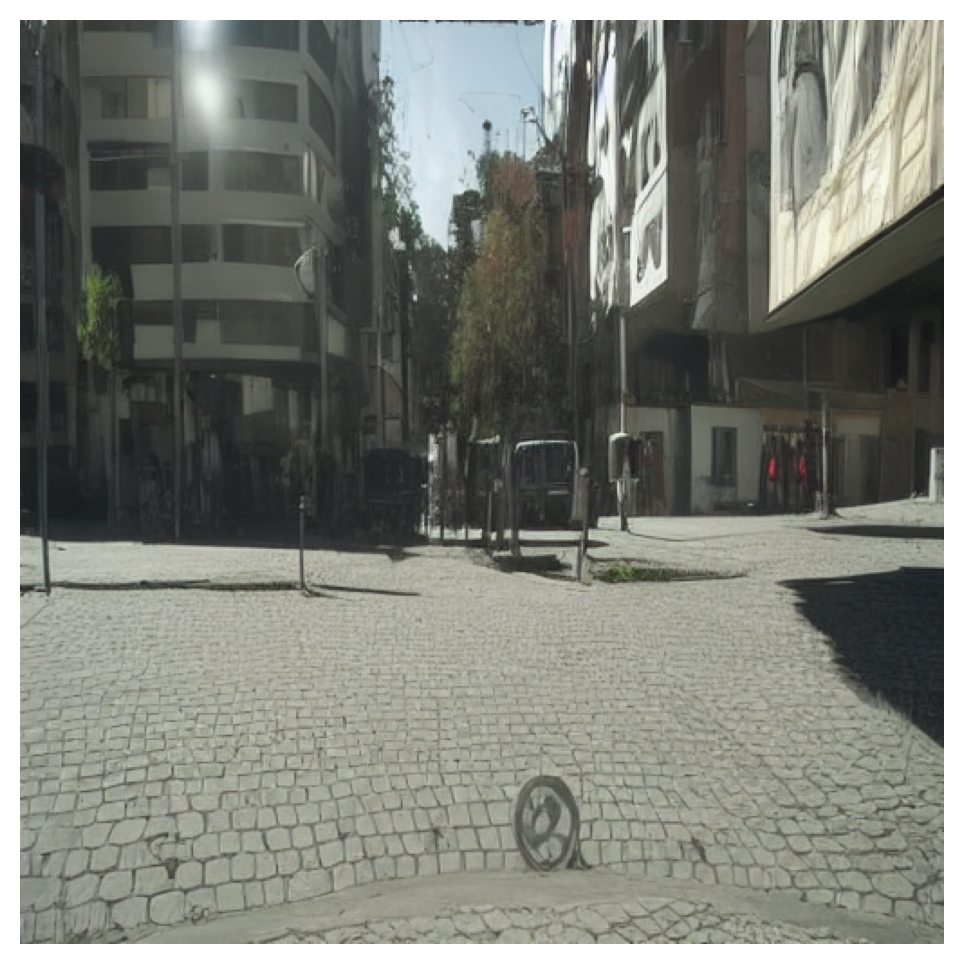

In [ ]:
result = generate_from_path("/content/00002.jpg")
# display(result)
plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(result)
plt.axis("off")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

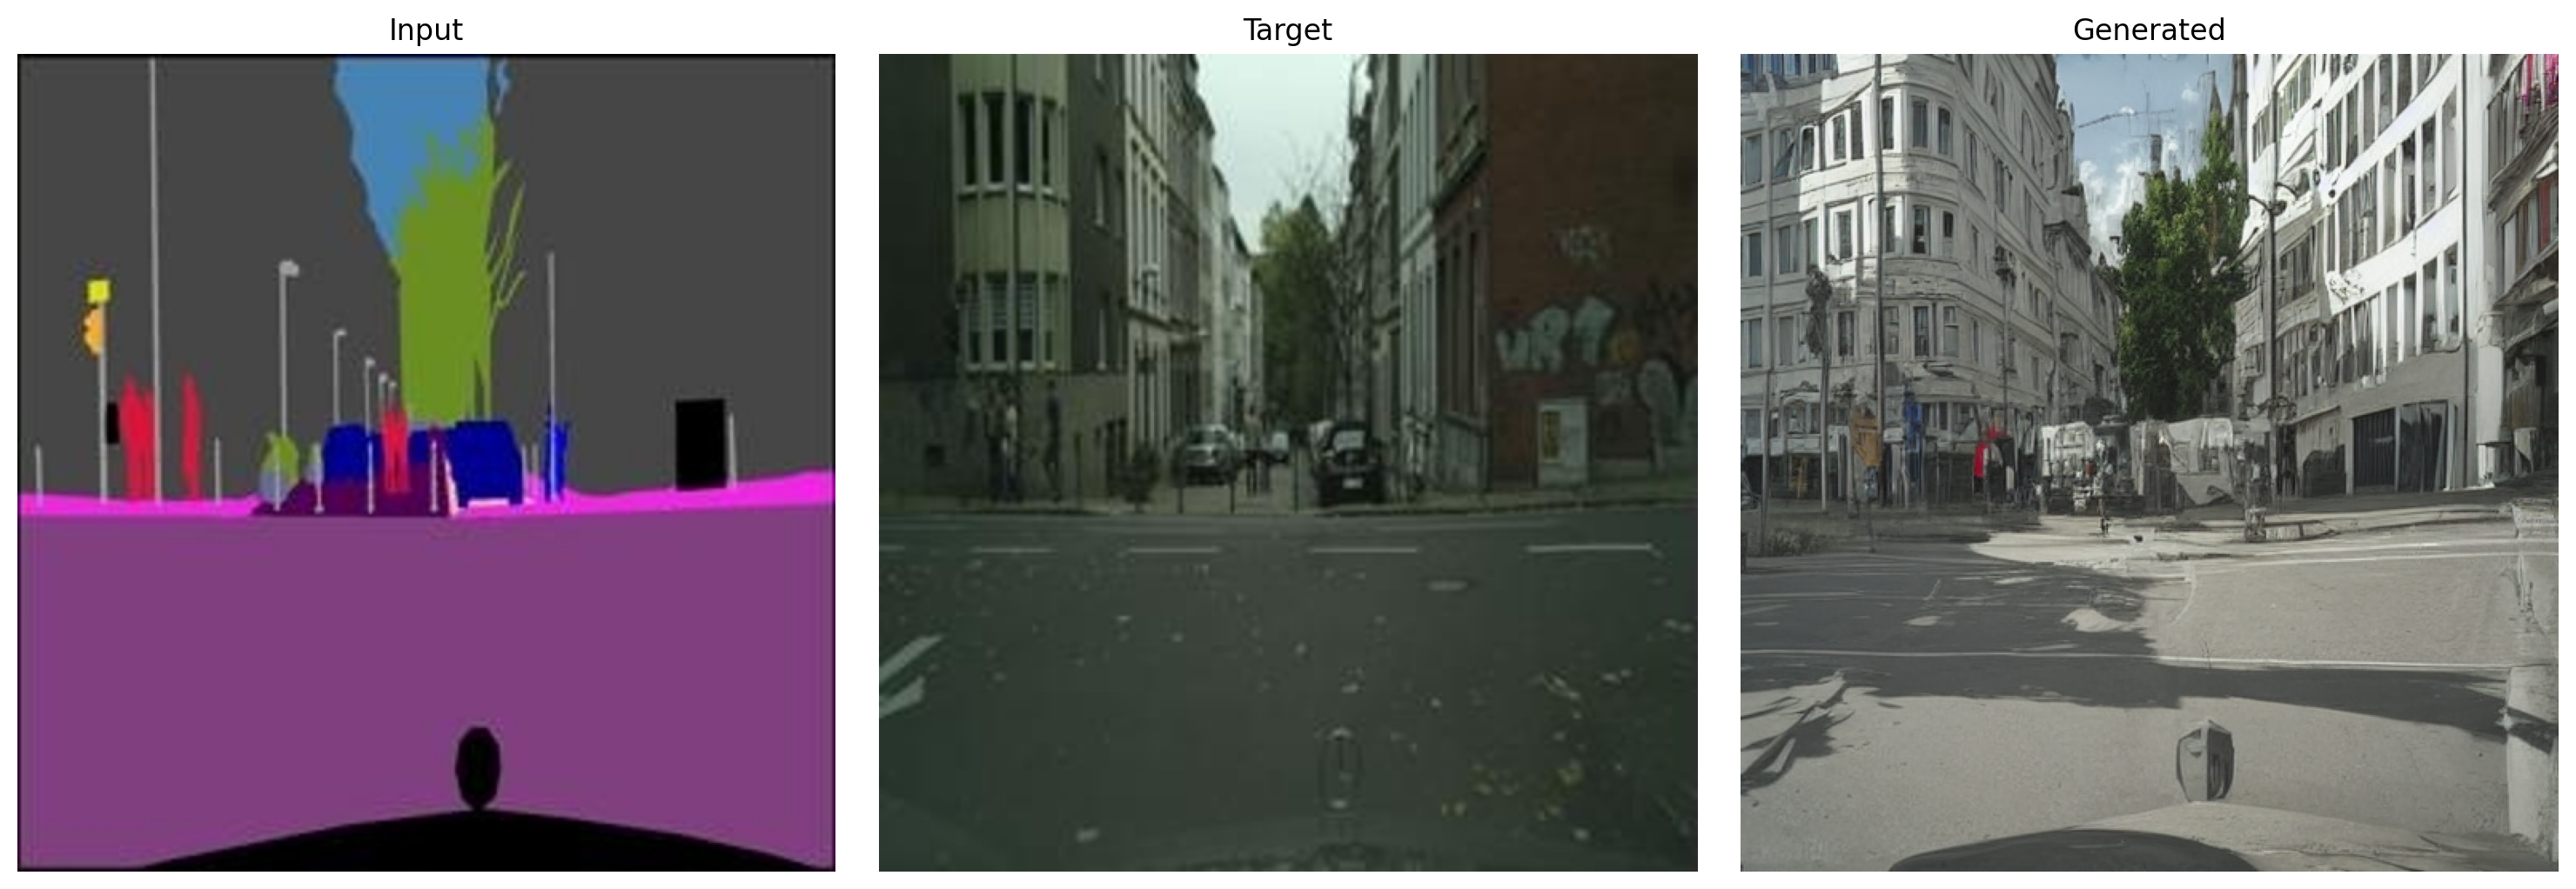

In [ ]:
display_triplet("/content/00002_input.jpg", "/content/00002_annot.jpg")